In [6]:
%mkdir trafic

In [7]:
%cp  /content/drive/MyDrive/trafic/*   /content/trafic

In [8]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [9]:
!pip install  albumentations==0.4.6

In [10]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

length of dataset =  148 

(224, 224, 3) 
 {'boxes': tensor([[ 14.5560,   9.8462,  62.2671, 184.6154],
        [167.3935,   1.2308, 215.1047, 174.7692],
        [ 94.6137,  13.5385, 142.3249, 188.3077]]), 'labels': tensor([1, 1, 1]), 'area': tensor([8338.4473, 8279.7246, 8338.4473]), 'iscrowd': tensor([0, 0, 0]), 'image_id': tensor([10])}


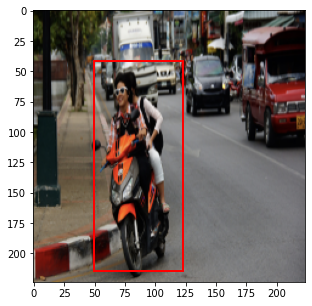

In [12]:


# defining the files directory and testing directory
files_dir = '/content/trafic'


class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        
        # classes: 0 index is reserved for background
        #self.classes = ["_", 'apple','banana','orange']
        self.classes = ["_", 'biker']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[10]
print(img.shape, '\n',target)


def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[98]
plot_img_bbox(img, target)

In [13]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [15]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [16]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [17]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [18]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/12]  eta: 0:00:33  lr: 0.000459  loss: 0.9575 (0.9575)  loss_classifier: 0.7471 (0.7471)  loss_box_reg: 0.1645 (0.1645)  loss_objectness: 0.0341 (0.0341)  loss_rpn_box_reg: 0.0119 (0.0119)  time: 2.7500  data: 0.6681  max mem: 7153
Epoch: [0]  [ 1/12]  eta: 0:00:24  lr: 0.000913  loss: 0.8900 (0.9238)  loss_classifier: 0.7201 (0.7336)  loss_box_reg: 0.1285 (0.1465)  loss_objectness: 0.0341 (0.0347)  loss_rpn_box_reg: 0.0061 (0.0090)  time: 2.2635  data: 0.3502  max mem: 7419
Epoch: [0]  [ 2/12]  eta: 0:00:20  lr: 0.001367  loss: 0.8900 (0.8797)  loss_classifier: 0.7201 (0.6964)  loss_box_reg: 0.1442 (0.1457)  loss_objectness: 0.0341 (0.0292)  loss_rpn_box_reg: 0.0071 (0.0084)  time: 2.0998  data: 0.2442  max mem: 7419
Epoch: [0]  [ 3/12]  eta: 0:00:18  lr: 0.001821  loss: 0.7915 (0.8359)  loss_classifier: 0.6220 (0.6319)  loss_box_reg: 0.1442 (0.1587)  loss_objectness: 0.0341 (0.0356)  loss_rpn_box_reg: 0.0071 (0.0097)  time: 2.0197  data: 0.1913  max mem: 7419
Epoch: [

In [19]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


In [20]:



#pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))


predicted #boxes:  7
real #boxes:  1


EXPECTED OUTPUT


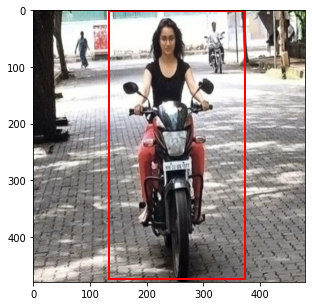

{'boxes': tensor([[133.2000,   1.6000, 373.2000, 475.2000]]), 'labels': tensor([1]), 'area': tensor([113664.0078]), 'iscrowd': tensor([0]), 'image_id': tensor([86])}
[1]
[[133.2   1.6 373.2 475.2]]
biker


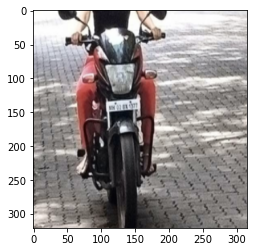

In [21]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)
print(target)
cr=target['boxes']
label=target['labels']
print(label.numpy())
print(cr.numpy())

classes = ['_', 'biker']
cls=classes[label]
print(cls)

im=torch_to_pil(img)
# Setting the points for cropped image 

dims=[122,134,437,455,]
left = 122
top = 134
right = 437
bottom = 455
  
# Cropped image of above dimension 
# (It will not change orginal image) 
im1 = im.crop((122,134,437,455)) 

plt.imshow(im1)
from PIL import ImageFont
from PIL import ImageDraw 

#
#im = Image.open('0.png').convert('L')
#im = im.crop((1, 1, 98, 33))
#im.save('_0.png')


MODEL OUTPUT


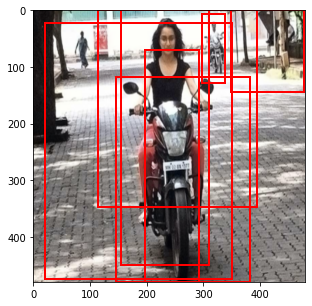

In [22]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


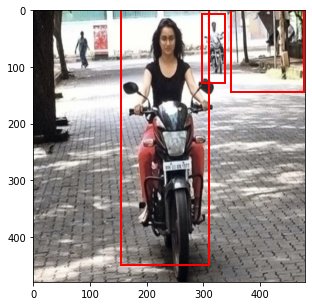

In [25]:
import numpy 
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
#nms=nms_prediction.detach().cpu().numpy()
#print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)


In [ ]:
img=Image.open("/content/bike.jpeg")


In [40]:
import cv2
from torchvision import transforms 

figure = cv2.imread('/content/duk.jpeg')
figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
transform=transforms.ToTensor()
t_i=transform(figure)
type(t_i)
t_i.size()

torch.Size([3, 190, 265])

In [41]:
img=t_i


MODEL OUTPUT



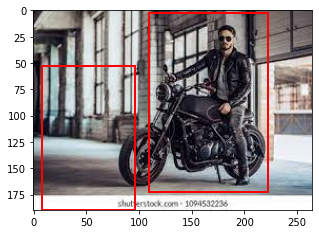

In [42]:
import cv2
from torchvision import transforms 

figure = cv2.imread('/content/dukkk.jpeg')
figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
transform=transforms.ToTensor()
t_i=transform(figure)
type(t_i)
t_i.size()

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
#plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.001)

plot_img_bbox(torch_to_pil(img), nms_prediction)


MODEL OUTPUT



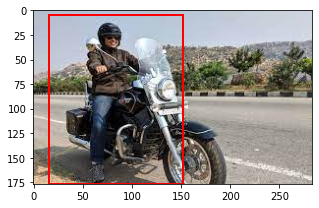

In [44]:
import cv2
from torchvision import transforms 

figure = cv2.imread('/content/dukkk.jpeg')
figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
transform=transforms.ToTensor()
t_i=transform(figure)
type(t_i)
t_i.size()
img=t_i
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
#plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.001)

plot_img_bbox(torch_to_pil(img), nms_prediction)
